# Least Square Classifier from scratch

# Background
- Used for estimating parameters of discriminant function from the give training data
- Adapts linear regression model for classification


In [ ]:
#@title Imports
from IPython.display import display, Math, Latex
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Implementation

In [ ]:
#@title [Polynomial Transformation]

import itertools
import functools

def get_combinations(x, degree):
  return itertools.combinations_with_replacement(x,degree)

def compute_new_feature(items):
  #reduce(lambda x,y:x*y, [1,2,3,4,5]) calculates ((((1*2)*3)*4)*5)
  return functools.reduce(lambda x, y:x*y,items)
  
#Implementation adopted from (https://github.com/ctgk/PRML/blob/master/prml/preprocess/polynomial.py)
def polynomial_transform(x, degree,logging=False):
  #Converts to feature matrix
  if x.ndim==1:
    x=x[:,None]
  x_t = x.transpose() #Transpose the feature matrix
  features = [np.ones(len(x))] #Populates 1s as first feature of each example
  print('feature-initial',features)
  if logging:
    print("Input:",x)
  for degree in range(1,degree+1):
    for items in get_combinations(x_t,degree): #generate combinations
      features.append(compute_new_feature(items))
      if logging:
        print(items,":",compute_new_feature(items))
  if logging:
    print(np.asarray(features).transpose())
  return np.asarray(features).transpose()

## Label Encoding

In [ ]:
class LabelTransformer(object):
  """
  Label encoder decoder
  Attributes
  ---------------
  n_classes:int
  number of classes,K
  """
  def __init__(self,n_classes:int=None):
    self.n_classes=n_classes

  @property
  def n_classes(self):
    return self.__n_classes
  
  @n_classes.setter
  def n_classes(self,K):
    self.__n_classes = K
    self.__encoder = None if K is None else np.eye(K)
  
  @property
  def encoder(self):
    return self.__encoder

  def encode(self, class_indices:np.ndarray):
    """
    encode class index into one-of-k code
    Parameters
    ----------------
    class_indices: (N,) np.ndarray
        non-negatice class index
        elements must be integer in (0, n_classes)
    Returns
    _____
    (N,K) np.ndarray
        one-of-k encoding of input
    """
    if self.n_classes is None:
      self.n_classes = np.max(class_indices)+1
    return self.encoder[class_indices]

  def decode(self, onehot:np.ndarray):
    """
    decode one-of-k code into class index
    Parameters
    ---------------
    onehot: (N,K) np.ndarray
      one-of-k code
    
    Returns
    ----------
    (N,) np.ndarray
        class index
    """
    return np.argmax(onehot,axis=1)


In [ ]:
binary_labels = LabelTransformer(2).encode(np.array([1,0,1,0]))
binary_labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [ ]:
multiclass_labels = LabelTransformer(3).encode(np.array([1,0,1,2]))
multiclass_labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
y=np.array([1,0,1,2])
class_ind = np.max(y)+1
encoder=np.eye(class_ind)
encoder

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

# Least Square classification implementation

In [ ]:
class LeastSquareClassification(object):

  def __init__(self):
    self.t0=20
    self.t1=1000

  def predict(self,X:np.ndarray) -> np.ndarray:
    ''' Prediction of output label for a given input.

    Args:
    X: Feature matrix for given inputs.

    Returns:
    y: Output label vector as predicted by the given model.
    '''
    #Check to make sure that the shapes are compatibel
    assert X.shape[-1]==self.w.shape[0], f"X shape{X.shape} and w shape {self.w.shape}, are not compatible"
    return np.argmax(X@ self.w,axis=-1)

  def predict_internal(self,X:np.ndarray)-> np.ndarray:
    '''Prediction of output lavel for a given input.
    Args:
    X: Feature matrix for given inputs.

    Returns:
    y: Output label vector as predicted by the given model.
    '''
    #Check to make sure that the shapes are compatibel
    assert X.shape[-1]==self.w.shape[0], f"X shape{X.shape} and w shape {self.w.shape}, are not compatible"
    return X@ self.w
  def loss(self,X:np.ndarray,y:np.ndarray,reg_rate:float) -> float:
    '''
    Calculates loss for a model based on known labels

    Args:
    X:Feature matrix for given inputs
    y: Output label vector as predicted by the given model

    Return:
    Loss
    '''
    e = y-self.predict_internal(X)
    return (1/2)*(np.transpose(e)@e)+(reg_rate/2)*(np.transpose(self.w)@self.w)

  def rmse(self, X,y,reg_rate):
    '''Calculates root mean squared error of prediction w.r.t actual label.'''
    return np.sqrt((2/X.shape[0])* self.loss(X,y,reg_rate))
  
  def fit(self,X:np.ndarray,y:np.ndarray,reg_rate:float) -> np.ndarray:
    '''Estimates parameters of the linear regression model with normal equation
    Args:
    X:Feature matrix for given inputs
    y: Output label vector as predicted by the given model

    Returns:
    Weight vector
    '''
    self.w = np.zeros((X.shape[1],y.shape[1]))
    eye = np.eye(np.size(X,1))
    self.w = np.linalg.solve(
                            reg_rate*eye + X.T @ X,
                             X.T@y,)
    return self.w

  def calculate_gradient(self,X,y,reg_rate:float):
    '''
    Calculate gradient of loss function w.r.t weight vector on training set.

    Arguments:
    X:Feature matrix for given inputs
    y: Output label vector as predicted by the given model

    Returns:
    A vector of gradients.
    '''
    return np.transpose(X)@(self.predict_internal(X)-y)+reg_rate*self.w

  def update_weights(self,grad,lr):
    return self.w-lr*grad

  def learning_schedule(self,t):
    return self.t0/(t+self.t1)

  def gd(self,X,y,num_epochs,lr,reg_rate:float):
    self.w = np.zeros((X.shape[1],y.shape[1]))
    self.w_all, self.err_all = [],[]
    for i in np.arange(0,num_epochs):
      dJdW = self.calculate_gradient(X,y,reg_rate)
      self.w_all.append(self.w)
      self.err_all.append(self.loss(X,y,reg_rate))
      self.w = self.update_weights(dJdW,lr)
    return self.w


  def sgd(self,X,y,num_epochs:int,reg_rate):
    self.w_all,self.err_all = [],[]
    self.w = np.zeros((X.shape[1],y.shape[1]))
    

    for epoch in range(num_epochs):
      for i in range(X.shape[0]):
        random_index = np.random.randint(X.shape[0])
        xi =X[random_index:random_index+1]
        yi =y[random_index:random_index+1]
        self.err_all.append(self.loss(xi,yi,reg_rate))

        gradients = 2 * self.calculate_gradient(xi,yi,reg_rate)
        lr = self.learning_schedule(epoch*X.shape[0]+i)

        self.w=self.update_weights(gradients,lr)
        self.w_all.append(self.w)
    return self.w

In [ ]:
z=np.array([[1,2],[3,4]])
np.size(z,1)

2

#### Graded-3

In [ ]:
class Classification(object):

  def __init__(self):
    self.t0=20
    self.t1=1000

  def predict(self,X:np.ndarray) -> np.ndarray:
    ''' Prediction of output label for a given input.

    Args:
    X: Feature matrix for given inputs.

    Returns:
    y: Output label vector as predicted by the given model.
    '''
    #Check to make sure that the shapes are compatibel
    assert X.shape[-1]==self.w.shape[0], f"X shape{X.shape} and w shape {self.w.shape}, are not compatible"
    return np.argmax(X@ self.w,axis=-1)

  def predict_internal(self,X:np.ndarray)-> np.ndarray:
    '''Prediction of output lavel for a given input.
    Args:
    X: Feature matrix for given inputs.

    Returns:
    y: Output label vector as predicted by the given model.
    '''
    #Check to make sure that the shapes are compatibel
    assert X.shape[-1]==self.w.shape[0], f"X shape{X.shape} and w shape {self.w.shape}, are not compatible"
    return X@ self.w
  def loss(self,X:np.ndarray,y:np.ndarray,reg_rate:float) -> float:
    '''
    Calculates loss for a model based on known labels

    Args:
    X:Feature matrix for given inputs
    y: Output label vector as predicted by the given model

    Return:
    Loss
    '''
    e = y-self.predict_internal(X)
    return (1/2)*(np.transpose(e)@e)+(reg_rate/2)*(np.transpose(self.w)@self.w)

  def rmse(self, X,y,reg_rate):
    '''Calculates root mean squared error of prediction w.r.t actual label.'''
    return np.sqrt((2/X.shape[0])* self.loss(X,y,reg_rate))
  
  def fit(self,X:np.ndarray,y:np.ndarray,reg_rate=0.001) -> np.ndarray:
    '''Estimates parameters of the linear regression model with normal equation
    Args:
    X:Feature matrix for given inputs
    y: Output label vector as predicted by the given model

    Returns:
    Weight vector
    '''
    self.w = np.zeros((X.shape[1],y.shape[1]))
    eye = np.eye(np.size(X,1))
    self.w = np.linalg.solve(
                            reg_rate*eye + X.T @ X,
                             X.T@y,)
    return self.w

In [ ]:
gsc=Classification()
def is_linearly_separable(X,y):
  # write your code here
    p = Perceptron()
    w_all = p.train(X, y, num_epochs=10)
    return np.allclose(w_all[-1], w_all[-2])

# Demonstration

Demonstration on folllowing setup:
1. Linearly seperable binary classification set up.
2. Linearly seperable binary classification set up with a few outlier points
3. Mult-class classification with k=3
4. Polynomial least square classification

In [ ]:
def create_toy_data(add_outliers=False, add_class=False):
  x0=np.random.normal(size=50).reshape(-1,2)-1
  x1=np.random.normal(size=50).reshape(-1,2)+1
  if add_outliers:
    x_1 = np.random.normal(size=10).reshape(-1,2)+np.array([5.,10.])
    return np.concatenate([x0,x1,x_1]),np.concatenate([np.zeros(25),np.ones(30)]).astype(np.int)
  if add_class:
    x2 = np.random.normal(size=50).reshape(-1,2)+2
    return np.concatenate([x0,x1,x2]),np.concatenate([np.zeros(25),np.ones(25),2+np.zeros(25)]).astype(np.int)
  return np.concatenate([x0,x1]),np.concatenate([np.zeros(25),np.ones(25)]).astype(np.int)


In [ ]:
##@title Data Preprocessing
from sklearn.model_selection import train_test_split

def preprocess(add_class=False, add_outliers=False, degree=1):
  x,y = create_toy_data(add_outliers,add_class)
  x_poly = polynomial_transform(x,degree=degree)
  x_train, x_test, y_train, y_test = train_test_split(x_poly,y)
  y_train_trans = LabelTransformer().encode(y_train)
  y_test_trans = LabelTransformer().encode(y_test)
  return x_train, x_test, y_train, y_test, y_train_trans, y_test_trans


In [ ]:
##@title Model visulaization

sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth":2.5})

def visualize_model(x_train, labels, lsc_obj, degree=1):
  f=plt.figure(figsize=(8,8))

  #compute xlim and ylim
  x1_min = np.min(x_train[:,1])
  x1_max = np.max(x_train[:,1])
  x2_min = np.min(x_train[:,2])
  x2_max = np.max(x_train[:,2])

  x1_test, x2_test, =np.meshgrid(np.linspace(x1_min, x1_max,100), np.linspace(x2_min,x2_max,100))
  x_test =np.array([x1_test,x2_test]).reshape(2,-1).T
  x_test_poly = polynomial_transform(x_test,degree=degree)
  y_test = lsc_obj.predict(x_test_poly)

  sns.scatterplot(data=x_train,x=x_train[:,1], y=x_train[:,2],hue=labels)
  plt.contourf(x1_test,x2_test,y_test.reshape(100,100),alpha=0.5,levels=np.linspace(0,1,3))
  plt.xlabel("$x_1$")
  plt.ylabel("$x_2$")
  plt.xlim(x1_min,x1_max)
  plt.ylim(x2_min,x2_max)
  plt.gca().set_aspect('equal',adjustable='box')
  plt.show()
  

## Demo-1: Linearly separable binary classification

In [ ]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans=preprocess()

feature-initial [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
print("\n Shape of training feature matrix:", x_train.shape)
print("Shape of label vector:", y_train.shape)
print("\n Shape of test feature matrix:", x_test.shape)
print("Shape of test label vector:", y_test.shape)


 Shape of training feature matrix: (37, 3)
Shape of label vector: (37,)

 Shape of test feature matrix: (13, 3)
Shape of test label vector: (13,)


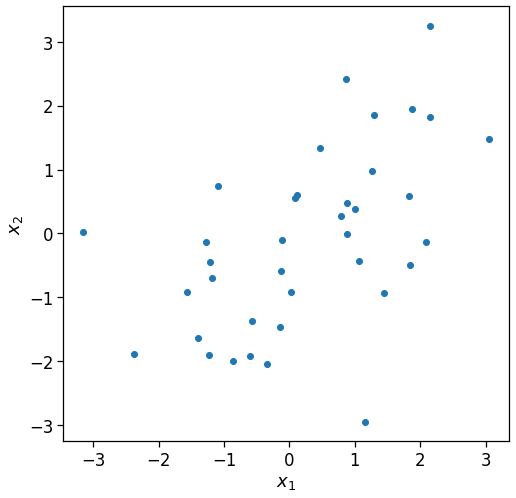

In [ ]:

f=plt.figure(figsize=(8,8))
sns.set_context("notebook", font_scale=1.5, rc={"linewidth":2.5})

sns.scatterplot(data=x_train,x=x_train[:,-2],y=x_train[:,-1],hue=y_train)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()


In [ ]:
lsc=LeastSquareClassification()

### Normal Equation

In [ ]:
x_train

array([[ 1.        , -1.27125904, -0.12790397],
       [ 1.        , -1.22182985, -1.89877894],
       [ 1.        , -0.86740808, -2.00364263],
       [ 1.        , -0.15065809, -1.46579379],
       [ 1.        ,  2.15284909,  3.24465417],
       [ 1.        , -1.09799608,  0.73560699],
       [ 1.        , -0.12058864, -0.10690414],
       [ 1.        , -1.5664151 , -0.92468492],
       [ 1.        ,  0.47292924,  1.3314513 ],
       [ 1.        ,  0.87551409,  0.47525543],
       [ 1.        ,  0.02140038, -0.91729659],
       [ 1.        , -0.13132028, -0.59683535],
       [ 1.        ,  1.00857436,  0.37982184],
       [ 1.        ,  1.29688889,  1.86022637],
       [ 1.        ,  1.06578347, -0.4369621 ],
       [ 1.        ,  0.11198577,  0.59601432],
       [ 1.        ,  3.05373654,  1.47261772],
       [ 1.        ,  1.45292925, -0.94096337],
       [ 1.        , -2.38116477, -1.88914815],
       [ 1.        , -0.34316191, -2.05237378],
       [ 1.        , -3.14971815,  0.025

In [ ]:
y_train

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0])

Weight vector [[ 0.54656723  0.45343277]
 [-0.19945301  0.19945301]
 [-0.13440955  0.13440955]]
feature-initial [array([1., 1., 1., ..., 1., 1., 1.])]


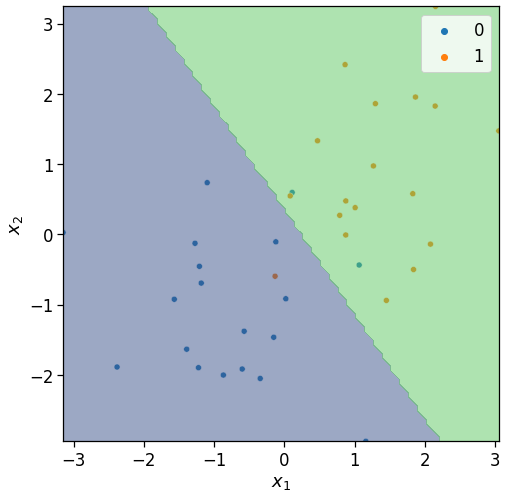

In [ ]:
lsc.fit(x_train, y_train_trans,reg_rate=0)
print("Weight vector",lsc.w)
visualize_model(x_train,y_train,lsc)

In [ ]:
np.allclose(lsc.w[-1],lsc.w[-2])

False

In [ ]:
def plot_learning_curve(err_all):
  err= [err[1][1] for err in err_all]
  plt.plot(np.arange(len(err)),err,'r-')
  plt.xlabel('Iter #')
  plt.ylabel('$\mathbf{J(w)}$')

### SGD

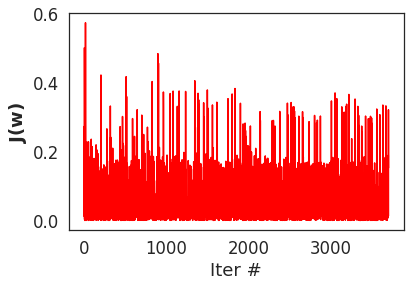

In [ ]:
lsc.sgd(x_train, y_train_trans, num_epochs=100,reg_rate=0)
plot_learning_curve(lsc.err_all)

feature-initial [array([1., 1., 1., ..., 1., 1., 1.])]


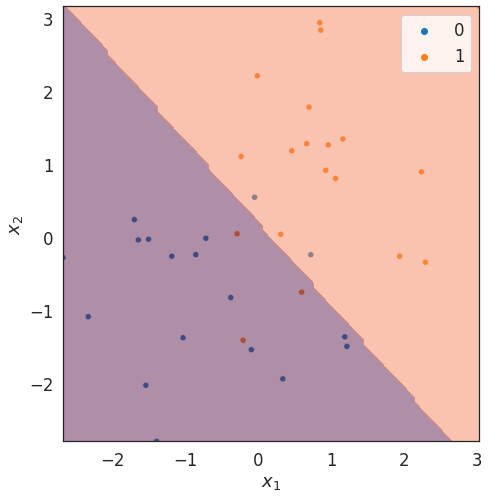

In [ ]:
visualize_model(x_train,y_train,lsc)

###GD

In [ ]:
lsc=LeastSquareClassification()
lsc.gd(x_train,y_train_trans,num_epochs=100,reg_rate=0,lr=1e-3)


array([[ 0.52550199,  0.43882174],
       [-0.18691787,  0.20733594],
       [-0.14591325,  0.12726365]])

In [ ]:
np.allclose(lsc.w_all[-1],lsc.w_all[-2])

False

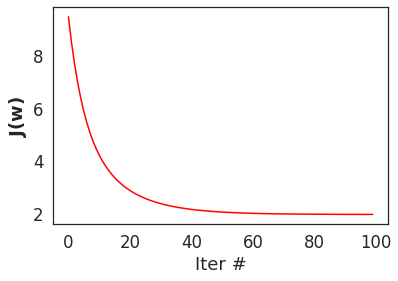

In [ ]:
plot_learning_curve(lsc.err_all)

feature-initial [array([1., 1., 1., ..., 1., 1., 1.])]


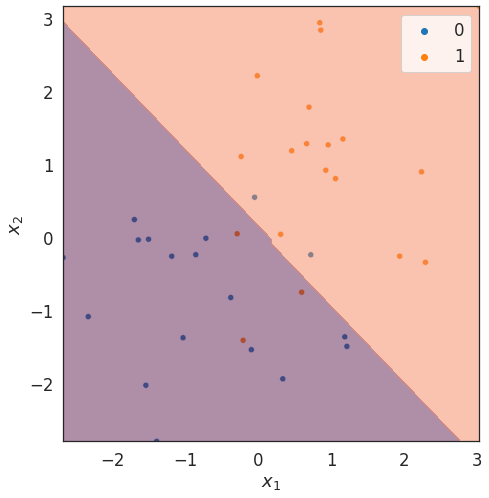

In [ ]:
visualize_model(x_train,y_train,lsc)

### Evaluation metrics

In [ ]:
print(x_test.shape)
y_test_hat = lsc.predict(x_test
                         )

(13, 3)


In [ ]:
tp= np.where((y_test==1)& (y_test_hat==1),1,0).sum()
tn= np.where((y_test==0)& (y_test_hat==0),1,0).sum()
fp= np.where((y_test==0)& (y_test_hat==1),1,0).sum()
fn= np.where((y_test==1)& (y_test_hat==0),1,0).sum()


In [ ]:
def precision(tp,fp):
  if(tp+fp)==0: return np.NaN
  return tp/(tp+fp)

In [ ]:
def recall(tp,fn):
  if(tp+fn)==0: return np.NaN
  return tp/(tp+fn)
  

In [ ]:
def accuracy(tp,fp,tn,fn):
  return (tp+tn)/(tp+tn+fp+fn)

In [ ]:
def f1_score(pr,r):
  return 2*((pr*r)/(pr+r))

### Classification metrics

In [ ]:
pr=precision(tp,fp)
r= recall(tp,fn)
print("Precision:",pr)
print("Recall:",r)
print("Accuracy:",accuracy(tp,fp,tn,fn))
print("F1 score", f1_score(pr,r))

Precision: 1.0
Recall: 0.8333333333333334
Accuracy: 0.9230769230769231
F1 score 0.9090909090909091


## Demo-2: Linearly separable binary classfication with outliers

In [ ]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans=preprocess(add_outliers=True)

feature-initial [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
print("\n Shape of training feature matrix:", x_train.shape)
print("Shape of label vector:", y_train.shape)
print("\n Shape of test feature matrix:", x_test.shape)
print("Shape of test label vector:", y_test.shape)


 Shape of training feature matrix: (41, 3)
Shape of label vector: (41,)

 Shape of test feature matrix: (14, 3)
Shape of test label vector: (14,)


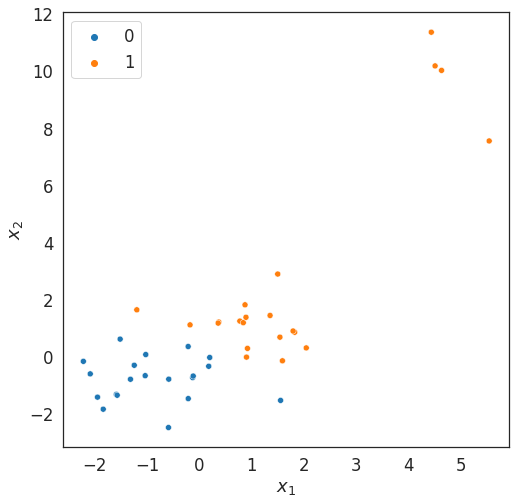

In [ ]:

f=plt.figure(figsize=(8,8))
sns.set_context("notebook", font_scale=1.5, rc={"linewidth":2.5})

sns.scatterplot(data=x_train,x=x_train[:,-2],y=x_train[:,-1],hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

feature-initial [array([1., 1., 1., ..., 1., 1., 1.])]


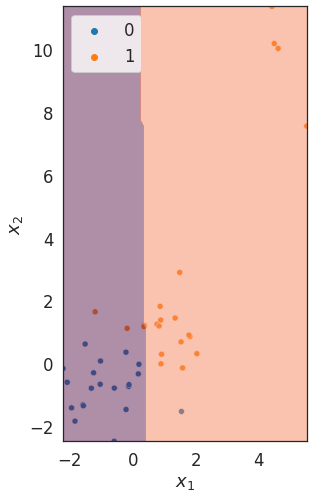

In [ ]:
lsc_outlier = LeastSquareClassification()
lsc_outlier.fit(x_train,y_train_trans,reg_rate=0)
visualize_model(x_train,y_train,lsc_outlier)

## Demo-3: Multiclass set up


In [ ]:
x_train, x_test, y_train, y_test, y_train_trans, y_test_trans=preprocess(add_class=True)

feature-initial [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


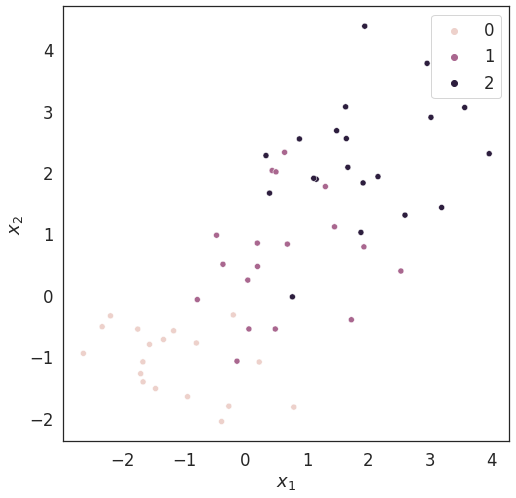

In [ ]:

f=plt.figure(figsize=(8,8))
sns.set_context("notebook", font_scale=1.5, rc={"linewidth":2.5})

sns.scatterplot(data=x_train,x=x_train[:,-2],y=x_train[:,-1],hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

In [ ]:
np.unique(y_train)

array([0, 1, 2])

feature-initial [array([1., 1., 1., ..., 1., 1., 1.])]


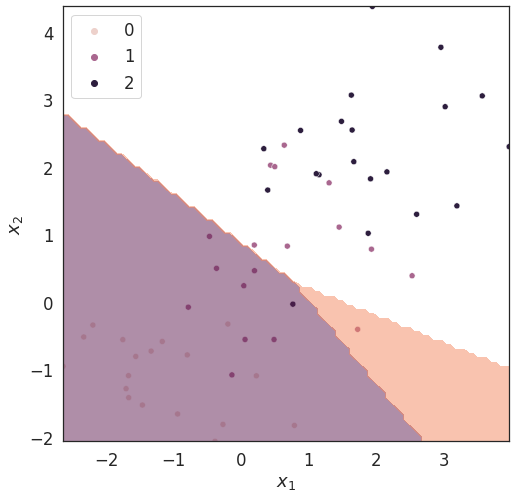

In [ ]:

lsc_multi_class = LeastSquareClassification()
lsc_multi_class.fit(x_train,y_train_trans,reg_rate=1)
visualize_model(x_train,y_train,lsc_multi_class)

In [ ]:
lsc_multi_class.w

array([[ 0.45835949,  0.31511066,  0.20606909],
       [-0.11745146,  0.02452838,  0.0933461 ],
       [-0.13313901, -0.01723694,  0.15457613]])

In [ ]:
from sklearn.metrics import classification_report

y_test_pred = lsc_multi_class.predict(x_test)
print(classification_report(y_test,y_test_pred,zero_division=0
                            ))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.00      0.00      0.00         7
           2       0.42      1.00      0.59         5

    accuracy                           0.58        19
   macro avg       0.42      0.62      0.48        19
weighted avg       0.43      0.58      0.47        19



## Demo-4: Polynomial Least square classification

In [ ]:
from sklearn.datasets import make_circles
x,y = make_circles()

In [ ]:
x_poly = polynomial_transform(x,degree=2)
x_train,x_test,y_train,y_test= train_test_split(x_poly,y)

feature-initial [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]


In [ ]:
x.shape

(100, 2)

In [ ]:
x_poly.shape

(100, 6)

In [ ]:
x[:5]

array([[-0.92977649,  0.36812455],
       [ 0.05023242, -0.79842138],
       [-0.2472136 , -0.76084521],
       [ 0.42577929,  0.90482705],
       [-0.06279052,  0.99802673]])

In [ ]:
x_poly[:5]

array([[ 1.        , -0.92977649,  0.36812455,  0.86448431, -0.34227355,
         0.13551569],
       [ 1.        ,  0.05023242, -0.79842138,  0.0025233 , -0.04010663,
         0.6374767 ],
       [ 1.        , -0.2472136 , -0.76084521,  0.06111456,  0.18809128,
         0.57888544],
       [ 1.        ,  0.42577929,  0.90482705,  0.18128801,  0.38525662,
         0.81871199],
       [ 1.        , -0.06279052,  0.99802673,  0.00394265, -0.06266662,
         0.99605735]])

In [ ]:
y_train_trans = LabelTransformer().encode(y_train)
y_test_trans = LabelTransformer().encode(y_test)

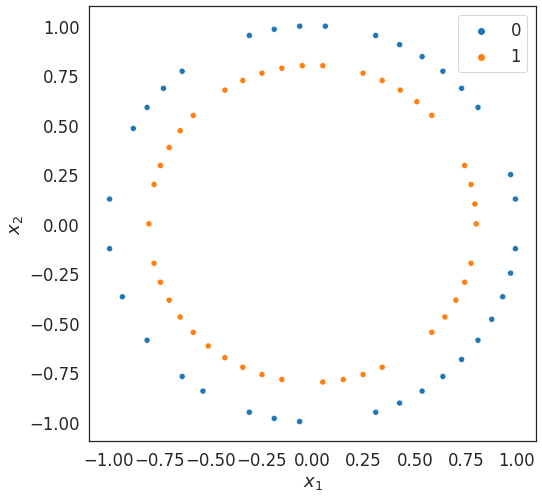

In [ ]:
f=plt.figure(figsize=(8,8))
sns.set_context("notebook", font_scale=1.5, rc={"linewidth":2.5})
sns.scatterplot(data=x_train,x=x_train[:,1],y=x_train[:,2],hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

feature-initial [array([1., 1., 1., ..., 1., 1., 1.])]


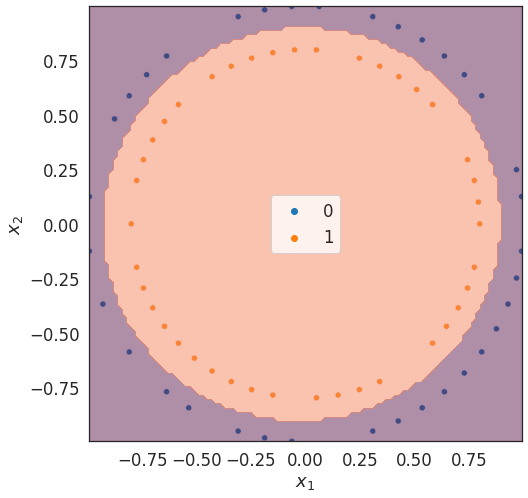

In [ ]:
lsc_poly = LeastSquareClassification()
lsc_poly.fit(x_train,y_train_trans,reg_rate=1)
visualize_model(x_train,y_train,lsc_poly,degree=2)

In [ ]:
from sklearn.metrics import classification_report

y_test_pred = lsc_poly.predict(x_test)
print(classification_report(y_test,y_test_pred,zero_division=0
                            ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        10

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



# Perceptron

In [ ]:
class Perceptron:
  def __init__(self):
    return
  
  def predict(self,X):
    z=X@self.w
    return np.where(z>=0,1,-1)

  def loss(self,X,y):
    return np.sum(np.maximum(-1*self.predict(X)*y,np.zeros(y.shape[0])))
  def train(self,X,y,epochs=10,lr=0.001):
    self.w = np.zeros(X.shape[1])
    self.errors_all=[]
    self.w_all = []

    for _ in range(epochs):
      errors = 0
      for xi, target in zip(X,y):
        self.w += lr * (target - self.predict(xi)) * xi
        errors += (max(-1 * self.predict(xi) * target, 0))
      self.errors_all.append(errors)
      self.w_all.append(self.w)
      print("w:",self.w)
      print("J(w)", self.errors_all[-1])

      # if self.loss(X,y)==0:
      #   break


In [ ]:
 class Perceptron(object):
  def __init__(self):
      pass
    
  def predict(self,X):
    z = X @ self.w
    return np.where (z >= 0, 1, -1)
 
  def loss(self,X,y,reg_rate):
    return np.sum(np.maximum(-1 * self.predict(X) * y, np.zeros(y.shape[0])))

  def fit(self,X, y, reg_rate=0):
    self.w = np.linalg.solve(X.T @ X + reg_rate * np.eye(X.shape[-1]), X.T@y)
    # print(X.shape, y.shape, self.w.shape)
    return self.w
  
  def train(self, X, y, num_epochs, lr=0.001):
    self.w = np.zeros(X.shape[1])
    self.w_all = []
    self.err_all = []
    for i in np.arange(0, num_epochs):
        errors = 0
        for xi, target in zip(X, y):
            self.w += lr * (target - self.predict(xi)) * xi
            errors += np.maximum(-1 * self.predict(xi) * y, np.zeros(y.shape[0]))
        self.err_all.append(errors)
        self.w_all.append(self.w)
#         print("w:", self.w)
#         print("J(w):", self.err_all[-1])
    return self.w

In [ ]:
def create_toy_data(factor=3):
    x0 = np.random.normal(size=50).reshape(-1, 2) - factor
    x1 = np.random.normal(size=50).reshape(-1, 2) + factor
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25)-1, np.ones(25)]).astype(np.int)

## Demonstration

### 1.  Linearly separable data

In [ ]:
from sklearn.model_selection import train_test_split
x,y = create_toy_data()
x_poly = polynomial_transform(x,degree=1)
x_train,x_test,y_train,y_test = train_test_split(x_poly,y)

feature-initial [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [ ]:
x_train.shape

(37, 3)

In [ ]:
y_train.shape

(37,)

w: [-2.         7.2882145  6.2879558]
J(w) 0
w: [-2.         7.2882145  6.2879558]
J(w) 0
w: [-2.         7.2882145  6.2879558]
J(w) 0
w: [-2.         7.2882145  6.2879558]
J(w) 0
w: [-2.         7.2882145  6.2879558]
J(w) 0
w: [-2.         7.2882145  6.2879558]
J(w) 0
w: [-2.         7.2882145  6.2879558]
J(w) 0
w: [-2.         7.2882145  6.2879558]
J(w) 0
w: [-2.         7.2882145  6.2879558]
J(w) 0
w: [-2.         7.2882145  6.2879558]
J(w) 0
feature-initial [array([1., 1., 1., ..., 1., 1., 1.])]


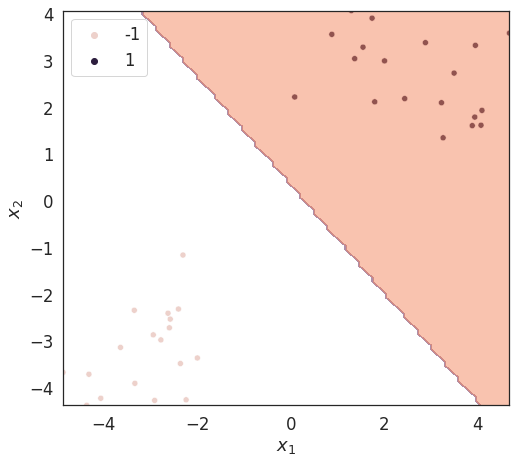

In [ ]:
perceptron_obj = Perceptron()
perceptron_obj.train(x_train,y_train,lr=1)
visualize_model(x_train,y_train,perceptron_obj,degree=1)

In [ ]:
perceptron_obj.errors_all

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Text(0.5, 1.0, 'Learning curve')

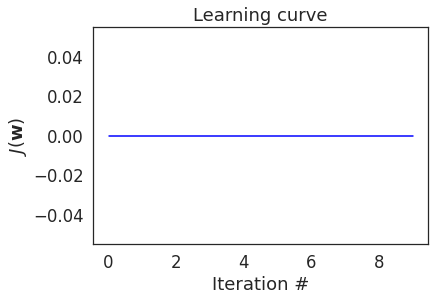

In [ ]:
plt.plot(np.arange(len(perceptron_obj.errors_all)),perceptron_obj.errors_all,'b-')
plt.xlabel('Iteration #')
plt.ylabel('$J(\mathbf{w})$')
plt.title('Learning curve')

### Linearly non-separable

In [ ]:
x,y = create_toy_data(factor=0.5)
x_poly = polynomial_transform(x,degree=1)
x_train,x_test,y_train,y_test = train_test_split(x_poly,y)
perceptron_obj = Perceptron()
perceptron_obj.train(x_train,y_train,lr=1)

feature-initial [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]
w: [ 0.         3.1212212 -0.4316022]
J(w) 5
w: [ 0.          2.15126079 -1.38967314]
J(w) 0
w: [ 0.          2.38170513 -2.04446143]
J(w) 0
w: [ 0.          2.61214948 -2.69924972]
J(w) 0
w: [ 0.          3.87142289 -2.97002399]
J(w) 3
w: [0.         2.54758926 0.38558992]
J(w) 3
w: [ 0.          2.92601488 -1.9208448 ]
J(w) 0
w: [ 2.          3.87987279 -1.86717535]
J(w) 1
w: [ 0.          2.82102635 -0.19299927]
J(w) 2
w: [ 2.          1.2745645  -3.34882928]
J(w) 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


feature-initial [array([1., 1., 1., ..., 1., 1., 1.])]


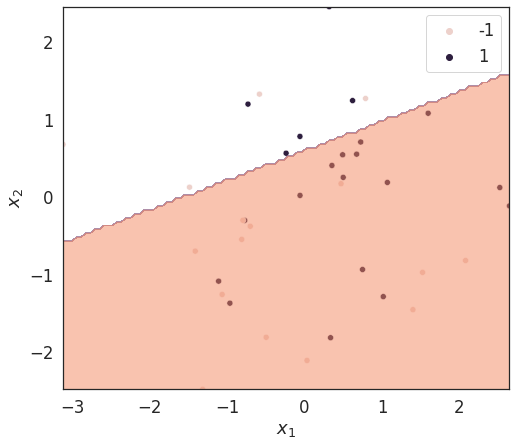

In [ ]:
visualize_model(x_train,y_train,perceptron_obj,degree=1)

Text(0.5, 1.0, 'Learning curve')

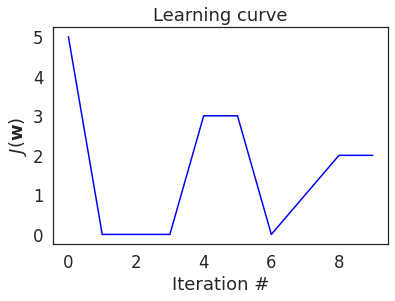

In [ ]:
plt.plot(np.arange(len(perceptron_obj.errors_all)),perceptron_obj.errors_all,'b-')
plt.xlabel('Iteration #')
plt.ylabel('$J(\mathbf{w})$')
plt.title('Learning curve')

### Non-linearly separable case

In [ ]:
from sklearn.datasets import make_circles
x,y = make_circles()

In [ ]:
x_poly = polynomial_transform(x,degree=2)
x_train,x_test,y_train,y_test= train_test_split(x_poly,y)

feature-initial [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_poly,y)
perceptron_obj = Perceptron()
perceptron_obj.train(x_train,y_train,lr=1)

w: [ 2.         -1.11754817  2.36111786 -1.35961139  0.04615961 -2.40038861]
J(w) 0
w: [ 4.         -0.01583409 -0.43688948 -4.55055502 -0.67974319 -1.52944498]
J(w) 0
w: [ 4.          0.37988146 -1.36451094 -5.14886181 -0.93634725 -3.09113819]
J(w) 0
w: [ 6.          1.64123958 -0.73834424 -3.8045156  -0.150338   -4.5954844 ]
J(w) 0
w: [ 4.          0.65693415  1.48452064 -6.04121807 -0.98848451 -5.07878193]
J(w) 0
w: [ 6.          0.22730168 -0.85202716 -5.98107004 -1.19317325 -6.01892996]
J(w) 0
w: [ 8.         -1.57961637  1.63415041 -6.08791315  0.20259671 -5.35208685]
J(w) 0
w: [ 8.          1.45142588 -0.24074245 -6.89467264 -0.58838926 -5.26532736]
J(w) 0
w: [ 8.          1.9040495  -0.09832105 -6.43511458 -0.1767361  -6.44488542]
J(w) 0
w: [ 8.          2.11329537 -1.27624288 -6.97860808 -0.99558096 -6.62139192]
J(w) 0


feature-initial [array([1., 1., 1., ..., 1., 1., 1.])]


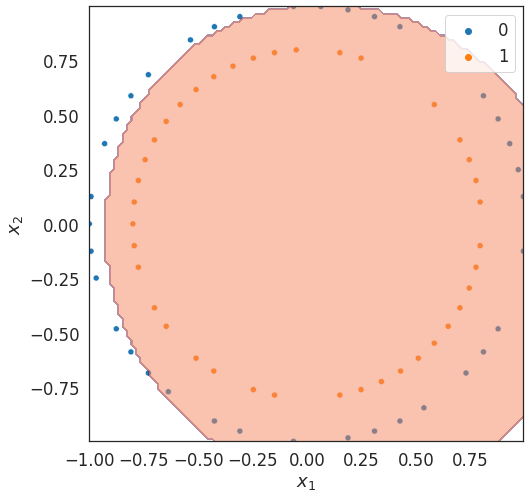

In [ ]:
visualize_model(x_train,y_train,perceptron_obj,degree=2)

Text(0.5, 1.0, 'Learning curve')

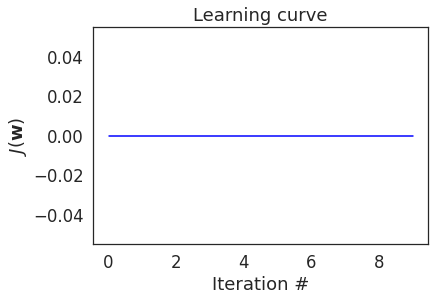

In [ ]:
plt.plot(np.arange(len(perceptron_obj.errors_all)),perceptron_obj.errors_all,'b-')
plt.xlabel('Iteration #')
plt.ylabel('$J(\mathbf{w})$')
plt.title('Learning curve')

In [ ]:
q=np.array([1,0,1,0])
len(np.unique(q))

2

# Practice Assignment

In [ ]:
features = np.array([[-0.909,-1.647],[-2.467,-0.407],[-1.321,-3.068],[3.054,0.704],[2.886,2.898],[2.739,1.404]])
label = np.array([0,0,0,1,1,1])
weight_vector = np.array([0.952,0.116])

In [ ]:
predict_label = features@weight_vector
e=label-predict_label
(1/2)*(np.transpose(e)@e)

10.445715152432

In [ ]:
z= features@weight_vector
y_predict = np.where(z>=0,1,-1)
np.sum(np.maximum(-1*y_predict*label,np.zeros((label.shape[0]))))

0.0